Goal: Predict total number of citibike rides each day, based on variables such as year,month,day of week, temperature. etc.

Steps:
- Will do for one year to start, then extend
- Get total # rides grouped by day
- Get daily temperatures
- Separate into predictors/target
- Train/test split
- Fit linear regression, Ridge, Lasso models and evaluate performance.

In [1]:
# import libraries and connect to database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
con = sqlite3.connect("data/citibike_database.db3")

In [2]:
year = 2015
query = "SELECT yday,wkday,count(*) as N FROM rides WHERE year=? GROUP BY yday"
df = pd.read_sql_query(query,con,params=[year])
df.head()

,yday,wkday,N
0,1,3,5317
1,2,4,11304
2,3,5,4478
3,4,6,7849
4,5,0,14506


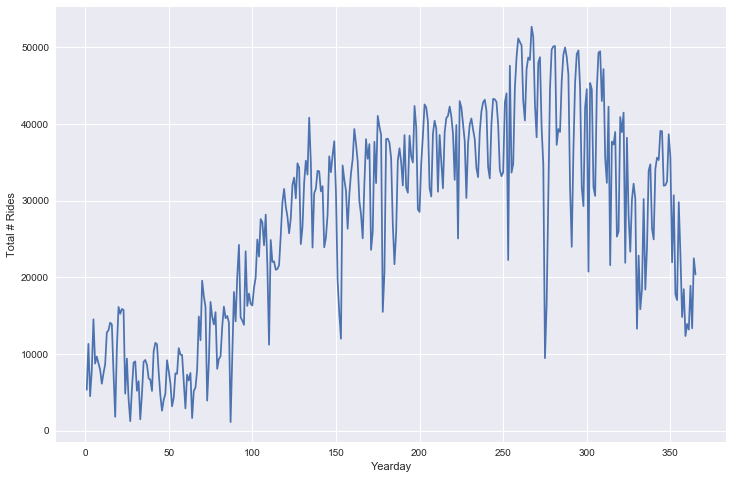

In [3]:
plt.figure(figsize=(12,8))
plt.plot(df.yday, df.N);
plt.xlabel('Yearday')
plt.ylabel('Total # Rides')

In [4]:
# get number of stations each day
query = "SELECT yday,count(distinct start_station_id) as N_sta FROM rides WHERE year=? GROUP BY yday"
df_sta = pd.read_sql_query(query,con,params=[year])
df_sta.head()

,yday,N_sta
0,1,327
1,2,327
2,3,323
3,4,329
4,5,330


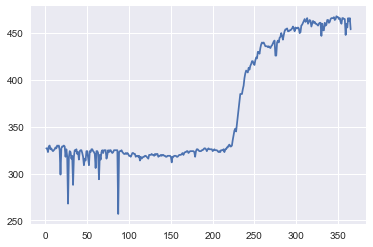

In [5]:
plt.plot(df_sta.yday, df_sta.N_sta)

In [6]:
con2 = sqlite3.connect('data/nyc_weather.db3')
query2 = "SELECT yday,Mean_TemperatureF as Tmean FROM temps WHERE year=?"
df2 = pd.read_sql_query(query2, con2, params=[year])
df2.head()

,yday,Tmean
0,1,33
1,2,39
2,3,36
3,4,49
4,5,36


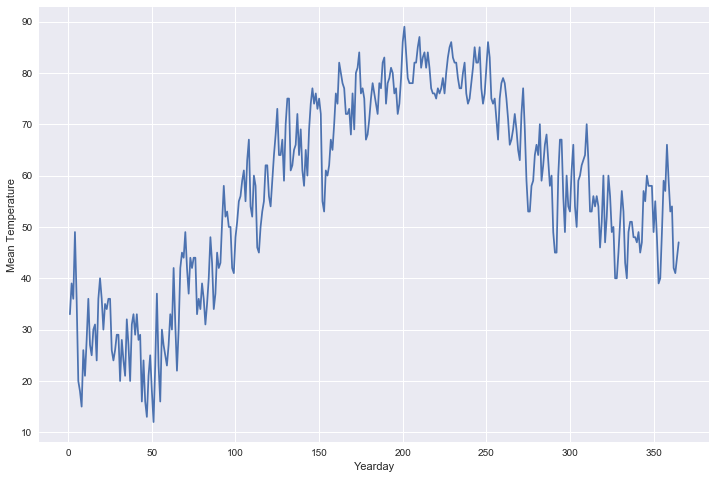

In [7]:
plt.figure(figsize=(12,8))
plt.plot(df2.yday, df2.Tmean);
plt.xlabel('Yearday')
plt.ylabel('Mean Temperature');

In [8]:
# join temps to rides data frame
df_comb = pd.merge(df,df2,left_on='yday',right_on='yday')
df_comb = pd.merge(df_comb, df_sta, left_on='yday',right_on='yday')
df_comb.head()

,yday,wkday,N,Tmean,N_sta
0,1,3,5317,33,327
1,2,4,11304,39,327
2,3,5,4478,36,323
3,4,6,7849,49,329
4,5,0,14506,36,330


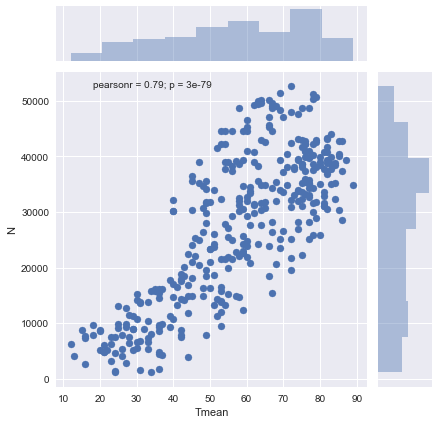

In [9]:
sns.jointplot(df_comb.Tmean,df_comb.N)

In [10]:
# dummy wkday
df_comb = pd.get_dummies(data=df_comb, columns=['wkday'])
df_comb.head()

,yday,N,Tmean,N_sta,wkday_0,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,1,5317,33,327,0,0,0,1,0,0,0
1,2,11304,39,327,0,0,0,0,1,0,0
2,3,4478,36,323,0,0,0,0,0,1,0
3,4,7849,49,329,0,0,0,0,0,0,1
4,5,14506,36,330,1,0,0,0,0,0,0


In [11]:
df_comb.head()

,yday,N,Tmean,N_sta,wkday_0,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,1,5317,33,327,0,0,0,1,0,0,0
1,2,11304,39,327,0,0,0,0,1,0,0
2,3,4478,36,323,0,0,0,0,0,1,0
3,4,7849,49,329,0,0,0,0,0,0,1
4,5,14506,36,330,1,0,0,0,0,0,0


In [12]:
# split data into predictor/target arrays in prep for modelling
X = df_comb.drop('N', axis=1)
X.head()

,yday,Tmean,N_sta,wkday_0,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,1,33,327,0,0,0,1,0,0,0
1,2,39,327,0,0,0,0,1,0,0
2,3,36,323,0,0,0,0,0,1,0
3,4,49,329,0,0,0,0,0,0,1
4,5,36,330,1,0,0,0,0,0,0


In [13]:
y = df_comb['N']
y.head()

0     5317
1    11304
2     4478
3     7849
4    14506
Name: N, dtype: int64

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X,y)


In [15]:
reg = LinearRegression()
reg.fit(X_train,y_train)
preds = reg.predict(X_test)


In [16]:
reg.score(X_train,y_train)

0.78093540771445469

In [17]:
reg.score(X_test,y_test)

0.835795000710438

In [18]:
cross_val_score(reg,X_train,y_train)

array([ 0.64589271,  0.75901132,  0.77653651])

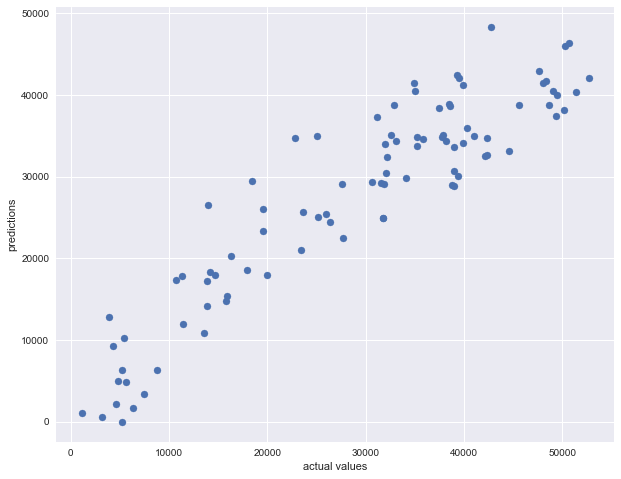

In [19]:
plt.figure(figsize=(10,8))
plt.scatter(y_test,preds)
plt.xlabel('actual values')
plt.ylabel('predictions')

In [20]:
reg.coef_

array([  -18.75062484,   566.11756639,    97.3417868 ,   927.66510392,
        1133.1598643 ,  2985.30949919,  1558.45442596,  1692.0167457 ,
       -3787.75680827, -4508.8488308 ])

In [21]:
coefs = pd.DataFrame({'vars':X.columns,'coef':reg.coef_})
coefs.sort_values('coef')

,coef,vars
9,-4508.848831,wkday_6
8,-3787.756808,wkday_5
0,-18.750625,yday
2,97.341787,N_sta
1,566.117566,Tmean
3,927.665104,wkday_0
4,1133.159864,wkday_1
6,1558.454426,wkday_3
7,1692.016746,wkday_4
5,2985.309499,wkday_2


## Next i'll try some linear regression models w/ regularization, which shoud reduce overfitting.

In [22]:
rid = Ridge()
rid.fit(X_train,y_train)
preds = rid.predict(X_test)
rid.score(X_train,y_train)

0.78090819762348063

In [23]:
rid.score(X_test,y_test)

0.83577719379018278

In [24]:
coefs = pd.DataFrame({'vars':X.columns,'coef':rid.coef_})
coefs.sort_values('coef')

,coef,vars
9,-4402.088126,wkday_6
8,-3683.288740,wkday_5
0,-18.816025,yday
2,97.439399,N_sta
1,566.197356,Tmean
3,904.154343,wkday_0
4,1103.892421,wkday_1
6,1521.936736,wkday_3
7,1645.431390,wkday_4
5,2909.961976,wkday_2


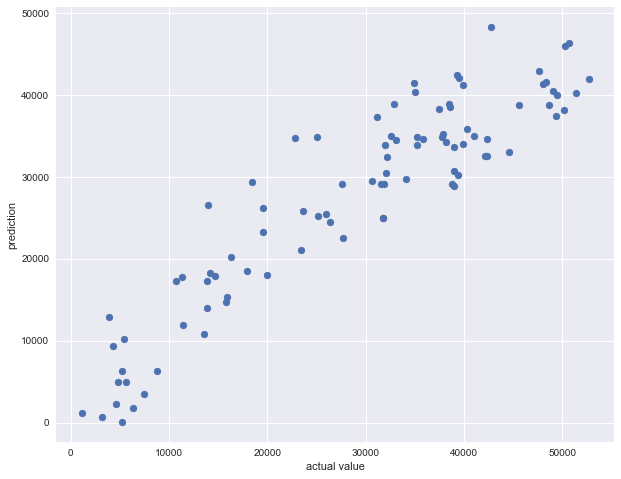

In [25]:
plt.figure(figsize=(10,8))
plt.scatter(y_test,preds)
plt.xlabel('actual value')
plt.ylabel('prediction')

In [26]:
cross_val_score(rid,X_train,y_train)

array([ 0.64767656,  0.75925392,  0.77785407])

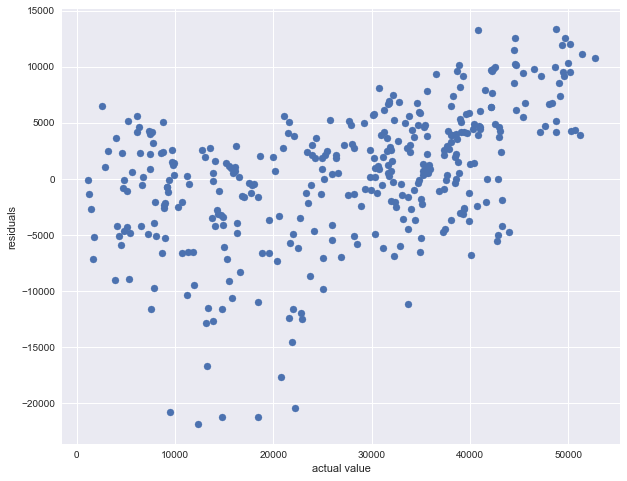

In [27]:
# look at residuals
plt.figure(figsize=(10,8))
preds = rid.predict(X)
resids = y-preds
plt.scatter(y,resids);
plt.xlabel('actual value')
plt.ylabel('residuals')
# looks like error/residual is corellated with y value
# model overestimates low values, and overestimates larger values??

Ridge model has parameter *alpha* we can tune, which controls the strength of the regularization; use GridSearchCV to try to optimize:

In [29]:
from sklearn.model_selection import GridSearchCV
rid = Ridge()
params = {'alpha':[0.1, 0.5, 1,2,5, 100]}
cv_rid = GridSearchCV(rid,params)
cv_rid.fit(X_train,y_train)
#rid.fit(X_train,y_train)
#preds = rid.predict(X_test)
#rid.score(X_train,y_train)
cv_rid.best_params_

{'alpha': 5}

In [30]:
cv_rid.best_score_

0.73091286991518856

In [31]:
# try lasso
from sklearn.linear_model import Lasso
las = Lasso(max_iter=4000)
params = {'alpha':[0.1, 0.5, 1,2,10, 100]}
cv_las = GridSearchCV(las,params)
cv_las.fit(X_train,y_train)
cv_las.best_params_
cv_las.best_score_

/Users/Andy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Andy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.73552833558053898

In [32]:
cv_las.score(X_test,y_test)

0.83470980801332062

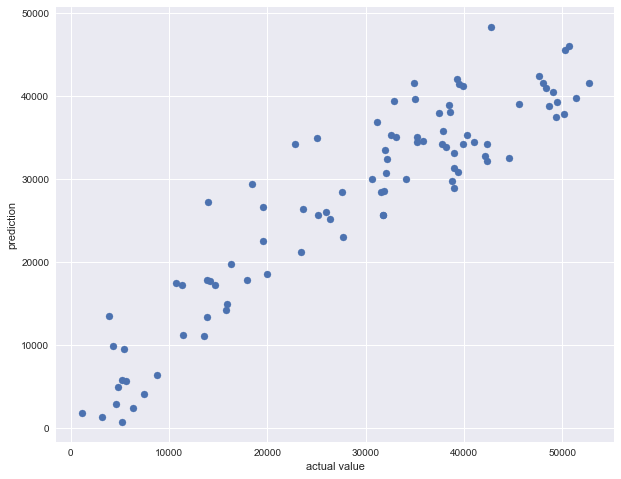

In [33]:
plt.figure(figsize=(10,8))
plt.scatter(y_test,cv_las.predict(X_test));
plt.xlabel('actual value')
plt.ylabel('prediction')

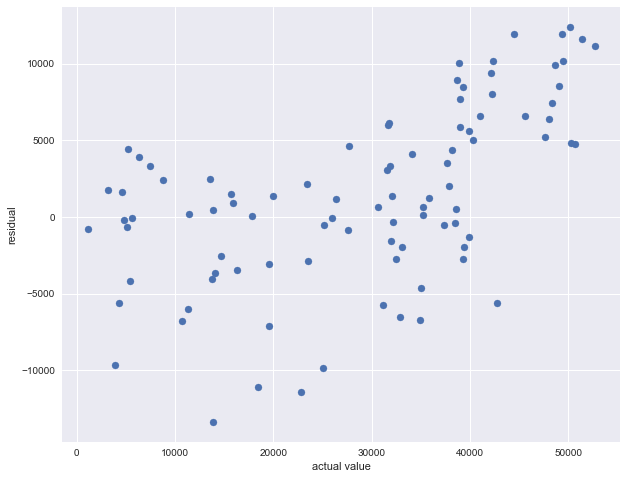

In [34]:
plt.figure(figsize=(10,8))
plt.scatter(y_test,y_test-cv_las.predict(X_test));
plt.xlabel('actual value')
plt.ylabel('residual')

In [37]:
# compare test-set scores of all3
print('LinReg test score: ' + str(reg.score(X_test,y_test)))
print('ridge test score: ' + str(cv_rid.score(X_test,y_test)))
print('Lasso test score: ' + str(cv_las.score(X_test,y_test)))


LinReg test score: 0.83579500071
ridge test score: 0.835332764349
Lasso test score: 0.834709808013


- Try using weekday/weekend as a variable w/ 2 categories?
- Try adding holidays?